## Reference (please appreciate and upvote the original authors): 
- https://www.kaggle.com/julian3833/jigsaw-incredibly-simple-naive-bayes-0-768
- https://www.kaggle.com/samarthagarwal23/mega-b-ridge-to-the-top-0-84 
- https://www.kaggle.com/leolu1998/jigsaw-ensemble-tfidf-bert
- https://www.kaggle.com/debarshichanda/pytorch-w-b-jigsaw-starter
- https://www.kaggle.com/debarshichanda/0-816-jigsaw-inference

This version adds a bit of nlp text preprocessing before feeding to the ridge regression models. I wanted to try if stop words removal will make the model perform worse or better. It seems the stop words removal improved the score(might not be true for the actual test dataset)

# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

# Training data 

## Convert the label to SUM of all toxic labels (This might help with maintaining toxicity order of comments)

In [2]:
df = pd.read_csv("train.csv")
print(df.shape)

for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(f'****** {col} *******')
    display(df.loc[df[col]==1,['comment_text',col]].sample(10))

(159571, 8)
****** toxic *******


,comment_text,toxic
22554,guess what?!?!? \n\nyour retarded,1
68349,THESE WIKIPEDIA PEOPLE ARE LIARS AND FASCISTS \n TABTAB \n TABTHEY BLOCKED ME BECAUSE THEY DIDN'T LIKE THE FACTS I POSTED ABOUT A CORRUPT BUSINESS-MAN!! THESE PEOPLE ARE LIARS AND THIS IS LIKE FASCIST GERMANY!! TAB \n TABTAB TABTAB \n TAB\n\nBLOCK THESE FASCISTS - Ryulong & Cacknuck are lying f...,1
122799,Listen Cuntboy \n\nYou're just a fag from north of the border. Don't know jack about the NEvada DOC. I fucked your wife asshole,1
84921,Guy Macon is a COXK SUXKER \n\nFUXK OFF AND DIE GUY!,1
74618,"""\n Yes, Apteva ... I do wish you yourself would learn to be civil and collegial. Your snide, sarcastic and snippy comments - plus the badgering of anyone who dares speak against you - show that civil and collegial are either not in your personal dictionary, or that you have long forgotten thei...",1
59931,I suppose you people are content to allow racist thugs to run riot on this article. Makes me sick. 86.45.211.71,1
1165,"""\n\nSo threatening to try to have me banned for editing is fine, but when I suggest having your account deleted for constantly deleting entire paragraphs, completely ignoring Wikipedia's policies with regards to that, instead of tagging or editing, suddenly it's bullying? Nonsense and you know ...",1
83283,David Duke\n\nWhy did you remove truth from the David Duke article. are you a racist?,1
81729,"""\n\nHoly crap.. Lest someone mistakenly visit a talk page, expecting to read some truth and hence be confused reading this gentleman's comment and mistaking the writer for someone who knows what they're talking about, I'd just like to point out the above explanation for the word """"handicap"""" is...",1
3419,"""\n\n{{unblock|DISCLAIMER: I do not identify as a Nazi, Neo-Nazi, Facist, Neo-Fascist. I do not accept or agree with the actions or views of Hitler or any other dictators in the world for that matter. I do not hate Jews... in fact I have many jewish friends...\nHello, although this is technicall...",1


****** severe_toxic *******


,comment_text,severe_toxic
115261,"well you can suck my balls gay fuck. Wikipedia is not censored, so I don't give a fuck about your feelings nor do I give a fuck about your grammar nazism because I the edit summary is not on the front page of the discussion... do you go calling foul to every grammar mistake in the discussion sec...",1
136645,... AmeriKKKans are fucking gay ... U.S.A. sucks balls\n\n'' ... The whole world hate U.S.A. incest population,1
12677,You suck your family members' cocks!,1
40809,Fucking krauts \n\nLearn to speak English you fucking dirty kraut!,1
21211,you are a fucking bawbag.\n\nget a real job you bumder and stop moaning to wikipedia you sack of spunk.\n\nim going to come to your house and rape your children.,1
120336,You know \n\nI am SO GOD DAMNED SICK of you holier than thou ****HEADS going in & reverting shit on a whim just cause you can! Get your shit straight before reverting shit!\n\n76.235.235.223,1
55910,"Listen, fuckers, why dont you all come say this shit to my face?",1
11726,"Toys/Pram eh ? Being persecuted by the big bad English again, awww diddums. Grow up you big fucking baby.",1
81805,""":::fuck you animal! remember this shit yourself, who do you think you are coming here with warnings and talking about """"being a dick"""" \n\n""",1
63217,Ajohnson170 is a son of a bitch and a dog-eating motherfucker.,1


****** obscene *******


,comment_text,obscene
46251,Shut up. I'm going to rape your sister,1
69439,From the rest of the world \ngo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck you...,1
56028,what the motherhell are you talking about? i deleted the lacrosse lie? you son need to get your facts straight i do not stand for this bullshit pigshit and treason.. no taxation without motherfucking representation son! Broad,1
78193,"I tried living off Guiness for a few weeks, I almost shit my internal organs out and had to spend a month in hospital 217.72.91.120",1
35012,u r a scum bag \n\nu r a effin homo i am the most inportantest person in the world u can call my article about Brittany Mellor nonesense but that is rejecting my and dat little badge that said kindness on ur sandbox yeah thats not true cuz I AM brittany mellor and calling me nonesense is effin s...,1
8448,Its harder than you think bithches,1
32438,To subject objective criteria such as references to subjective quasi-criteria such as Google count on a topic as humanistic as genocide undoubtedly does seem fitting of a profile of someone who treats genocide v. its deniers same as ice cream v. its taste-variants. Too bad I didn't succeed piss...,1
127307,"Big ass warning type thing: You step to me on my user page, and I reserve the right to tell you to rack off, in any number of ways which may damage your ego. You act nice and civil here, and I'll do the same. Note, if you post random unhelpful shit, I will tell you to rack off as well. Be a j...",1
159298,", are you dumber than you look? asshole.",1
136217,Anonymous \n\nYou gay Afambro fuck you,1


****** threat *******


,comment_text,threat
81428,AN UGLY CHILD AND I WILL KILL YOU LIKE A CAT IN A BOX.....maybe.,1
110554,"""\n\n Bye Bye Jerk! \n\nI guess this means you will be crying about the Nazis anymore. What is your problem with Nazis anyway? Did you date a Nazi woman and she broke your heart?? What a shame!!!\n\nYour life isn't worth living anymore so pleasee KILL YOURSELF!\n\nYou know I'm right. You've ...",1
134175,"hello. i know where you live. i know what you did last summer. i'm coming to get you. yes, you. you better watch your back. you'll never know when i'm coming, but i'm coming. when you least expect it.",1
73134,I'm going to track you down \n\nI am going to track you down and do horrible violent things to you. This is a sincere threat which I would take seriously if I were you.\n\nBEHEAD THOSE WHO INSULT ISLAM 82.165.144.51,1
43507,Go and hang yourself!,1
157631,I Want You \n\nI wanna rape you good. I want your sexy body and sexually abuse you!,1
62619,. I hope you die of cancer,1
30566,"""\n\n""""I think we should kill all the jews and homosexuals and handicaped people."""", (said Adolf Hitler).""",1
100939,I like you \n\nI kill you last.,1
90339,"Next time this happens i won't just report it, I'll eat your children. Rarghhhh! You can't fuck wit me bitch! I am the fuckin' heavyweight champion of the world! I'll eat your face!",1


****** insult *******


,comment_text,insult
40108,Haha. Go ahead. Stupid American.,1
43343,"What kind of idiot ARE you??? \n\nOBVIOUSLY you can't f***ing READ! I ASKED for someone to add one of more of those images I provide to the entry. INSTEAD, your retarded *** simply reverts the damn thing! \n\nCAN YOU NOT UNDERSTAND FRICKEN ENGLISH OR SOMETHING????\n\n75.8.35.177",1
132992,NIGGERS ARE BLACK. WHY IS THIS?,1
56556,your gay douche like gay porno ahaghagagagaa,1
60782,"her!\n\nPoop, pee, toot, fart, gas, diareah!\n\nZoey is poop. She stinks.\n\nI want to marry you baby! Call me!\n\nSTOP DELETING THIS!",1
40219,heres ya stupid signature as well you faggots129.234.155.162,1
71073,stupid fuckin editors \n\nthey should all go and fuck themselves,1
85239,fuck u bitch so fuck off and im doing this cuz im a terroris bitch,1
103217,Sspx \n\nYou should join that autistic Pope in Rome and go fuck yourselves with Sin until all your maggot brains turn into soup.,1
113841,You're easy to wind up you pommy bastard. Get a job!,1


****** identity_hate *******


,comment_text,identity_hate
60958,FUCK YOU Jdelanoy. You are German COCK SUCKER & FUCKER MOTHER FUCKER. Good to know how you FUCKED face looks.,1
124998,"Sallary controversy \n\nArzel, watch your back on the street\n\ndelete the truth , ill cut you on the street\n\nThe president of the Peabody Essex Museum Dan Monroe makes $578,254.00 a year with full benefits while all the guards are part time with no benefits.\n\nthis edit was undone by you, y...",1
144399,You piece of shit fucking block me then pussy... Go ahead I don't give a care if you are that of a fucking girly bitch! FUCK YOU Boing! Said Zebedee! What the fuck kind of user is that? Fucking mindless block addict retard,1
97145,"Homos on Wikipedia \n\nHi Chris! Thanks for becoming part of the Wikipedia community! However, there re lots of homos who edit Wikipedia. Here is a list of all the homos on Wikipedia. I hope you can set them on the straight path, because God and Jesus hate sodomy!",1
72593,Fucking Dutch motherfucker. Fuck off faggot.,1
86685,"Fucking Bastard \nyou son of a bitch, asshole, motherfucker, go fuck ur mothers cunt, trade ur wife sister",1
82653,Eat shit nigger \n\nI cant be blocked I have infinite ips,1
111813,"""\n\n HA! \n\nyou are gay!, what the f**k, hahahahaha. Damn! They told you straight out, I was wondering too, especially when you said, """"I sometimes talk using my normal voice, and sometimes in a high, silly voice."""" that's some gay sh*t right there. This should go in the main page. HAHAhAHHAAH...",1
143477,fucking germanian piece of shit,1
158498,n ig ger nig ger \n\nHi n i g g e r,1


In [3]:

# Give more weight to severe toxic 
df['severe_toxic'] = df.severe_toxic * 2
df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) ).astype(int)
df['y'] = df['y']/df['y'].max()

df = df[['comment_text', 'y']].rename(columns={'comment_text': 'text'})
df.sample(5)

,text,y
159528,"Wikipedia:Articles for deletion/Markus Kaarlonen \n\nThe article about Markus Kaarlonen was proposed for deletion due to the lack of reliable sources in his article. I have added several sources, but more are needed. Please contribute to the article by adding reliable sources, or at least let me...",0.000000
138435,"Um its like totally my RIGHT as a free human being (i do not liv in israel or palestin) to voice my OPINION even if it disagrees with yours. god, u shud have learned this stuff in kindergarten. i wasn't trying to mess up your article or this mess of a convo. so go bak to pretending to be sage an...",0.000000
61766,"""\nSince this Ashleigh Ball has 42 times the page views of the only other Ashleigh Ball (20639 vs. 488 over the last 90 days, or 97.7 percent of all page views for people named """"Ashleigh Ball"""") and even the disambiguation page gets nearly four times the page views of the other Ashleigh Ball (1...",0.000000
123016,"September 2015 (UTC)\n\nOk Thanks!!! 08:52, 3",0.000000
126020,Eli is not a crack whore and works the streets for money. if you want him go the the burbs and yell out two headed white bitch raper.,0.285714


In [4]:
df['y'].value_counts()

0.000000    143346
0.142857      6360
0.428571      4064
0.285714      3439
0.714286      1064
0.571429       938
0.857143       329
1.000000        31
Name: y, dtype: int64

## Create 3 versions of the data

In [5]:
n_folds = 7

frac_1 = 0.7
frac_1_factor = 1.5

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))

    tmp_df.to_csv('tmp.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(28394, 2)
0.000000    17036
0.142857     4433
0.428571     2823
0.285714     2442
0.714286      742
0.571429      673
0.857143      223
1.000000       22
Name: y, dtype: int64
Fold: 1
(28394, 2)
0.000000    17036
0.142857     4432
0.428571     2840
0.285714     2391
0.714286      751
0.571429      685
0.857143      237
1.000000       22
Name: y, dtype: int64
Fold: 2
(28394, 2)
0.000000    17036
0.142857     4472
0.428571     2818
0.285714     2404
0.714286      735
0.571429      661
0.857143      248
1.000000       20
Name: y, dtype: int64
Fold: 3
(28394, 2)
0.000000    17036
0.142857     4469
0.428571     2842
0.285714     2415
0.714286      719
0.571429      657
0.857143      240
1.000000       16
Name: y, dtype: int64
Fold: 4
(28394, 2)
0.000000    17036
0.142857     4437
0.428571     2869
0.285714     2389
0.714286      745
0.571429      679
0.857143      218
1.000000       21
Name: y, dtype: int64
Fold: 5
(28394, 2)
0.000000    17036
0.142857     4480
0.428571     2840
0.

# Create 3 versions of __clean__ data

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DP571\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

def clean(data, col):

    # Clean some punctutations
    data[col] = data[col].str.replace('\n', ' \n ')
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3')
    # Replace repeating characters more than 3 times to length of 3
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    # Add space around repeating characters
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ')    
    # patterns with repeating characters 
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1')
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    return data

In [8]:
# Test clean function
test_clean_df = pd.DataFrame({"text":
                              ["heyy\n\nkkdsfj",
                               "hi   how/are/you ???",
                               "hey?????",
                               "noooo!!!!!!!!!   comeone !! ",
                              "cooooooooool     brooooooooooo  coool brooo",
                              "naaaahhhhhhh"]})
display(test_clean_df)
clean(test_clean_df,'text')

,text
0,heyy\n\nkkdsfj
1,hi how/are/you ???
2,hey?????
3,noooo!!!!!!!!! comeone !!
4,cooooooooool brooooooooooo coool brooo
5,naaaahhhhhhh


,text
0,heyy kkdsfj
1,hi / are/you ???
2,hey ???
3,noo !!! comeone !!
4,coool broo coool broo
5,naaahh


In [9]:
df = clean(df,'text')

In [10]:
df[df.y==0]

,text,y
0,"Explanation Why edits made username Hardcore Metallica Fan reverted ? They ' vandalisms, closure GAs I voted New York Dolls FAC. And please ' remove template talk page since I ' retired now.89.205.38.27",0.0
1,"D ' aww ! He matches background colour I ' seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0.0
2,"Hey man, I ' really trying edit war. It ' guy constantly removing relevant information talking edits instead talk page. He seems care formatting actual info.",0.0
3,""" More I ' make real suggestions improvement - I wondered section statistics later on, subsection """"types accidents"""" -I think references may need tidying exact format ie date format etc. I later on, no-one else first - preferences formatting style references want please let know. There appears ...",0.0
4,"You, sir, hero. Any chance remember page ' ?",0.0
...,...,...
159566,""":::::And second time asking, view completely contradicts coverage reliable sources, anyone care feel ? You ' even give consistent argument - opening supposed mention significant aspects, """"most significant"""" ones ? """,0.0
159567,You ashamed That horrible thing put talk page. 128.61.19.93,0.0
159568,"Spitzer Umm, theres actual article prostitution ring. - Crunch Captain.",0.0
159569,And looks like actually put speedy first version deleted I look it.,0.0


In [11]:
n_folds = 7

frac_1 = 0.7
frac_1_factor = 1.5

for fld in range(n_folds):
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , 
                        df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , 
                                            random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))

    tmp_df.to_csv('tmp.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

(28394, 2)
0.000000    17036
0.142857     4433
0.428571     2823
0.285714     2442
0.714286      742
0.571429      673
0.857143      223
1.000000       22
Name: y, dtype: int64
(28394, 2)
0.000000    17036
0.142857     4432
0.428571     2840
0.285714     2391
0.714286      751
0.571429      685
0.857143      237
1.000000       22
Name: y, dtype: int64
(28394, 2)
0.000000    17036
0.142857     4472
0.428571     2818
0.285714     2404
0.714286      735
0.571429      661
0.857143      248
1.000000       20
Name: y, dtype: int64
(28394, 2)
0.000000    17036
0.142857     4469
0.428571     2842
0.285714     2415
0.714286      719
0.571429      657
0.857143      240
1.000000       16
Name: y, dtype: int64
(28394, 2)
0.000000    17036
0.142857     4437
0.428571     2869
0.285714     2389
0.714286      745
0.571429      679
0.857143      218
1.000000       21
Name: y, dtype: int64
(28394, 2)
0.000000    17036
0.142857     4480
0.428571     2840
0.285714     2384
0.714286      747
0.571429      

In [12]:
del df,tmp_df
gc.collect()

30

## Ruddit data

(5838, 5)


<AxesSubplot:>

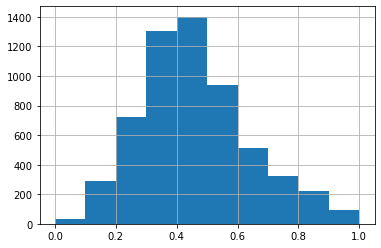

In [13]:
df_ = pd.read_csv("ruddit_with_text.csv")
print(df_.shape)

df_ = df_[['txt', 'offensiveness_score']].rename(columns={'txt': 'text',
                                                                'offensiveness_score':'y'})

df_['y'] = (df_['y'] - df_.y.min()) / (df_.y.max() - df_.y.min()) 
df_.y.hist()

# Create 3 versions of data

In [14]:
n_folds = 7

frac_1 = 0.7

for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = df_.sample(frac=frac_1, random_state = 10*(fld+1))
    tmp_df.to_csv('tmp.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(4087, 2)
0.464668    125
0.475910    106
0.375268     94
0.442719     92
0.364561     89
           ... 
0.889722      1
0.883298      1
0.658458      1
1.000000      1
0.694861      1
Name: y, Length: 268, dtype: int64
Fold: 1
(4087, 2)
0.464668    107
0.475910    103
0.408994    102
0.386510     97
0.353319     88
           ... 
0.606531      1
0.942719      1
0.954497      1
0.829229      1
0.000000      1
Name: y, Length: 264, dtype: int64
Fold: 2
(4087, 2)
0.464668    118
0.475910    102
0.386510     94
0.442719     92
0.364561     89
           ... 
0.717880      1
0.658458      1
1.000000      1
0.400964      1
0.694861      1
Name: y, Length: 265, dtype: int64
Fold: 3
(4087, 2)
0.464668    116
0.475910    106
0.386510     93
0.408994     92
0.364561     90
           ... 
0.427195      1
0.131156      1
0.883298      1
0.717880      1
0.694861      1
Name: y, Length: 263, dtype: int64
Fold: 4
(4087, 2)
0.464668    122
0.475910    114
0.386510    100
0.442719     91
0.

In [15]:
del tmp_df, df_; 
gc.collect()

30

## Load Validation and Test data  


In [16]:
# Validation data 

df_val = pd.read_csv("validation_data.csv")

In [17]:
# Test data

df_sub = pd.read_csv("comments_to_score.csv")


# Create Sklearn Pipeline with 
## TFIDF - Take 'char_wb' as analyzer to capture subwords well
## Ridge - Ridge is a simple regression algorithm that will reduce overfitting 

In [18]:
# NOT USED 
class LengthTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix([[(len(x)-360)/550] for x in X])
    def get_feature_names(self):
        return ["lngth"]

class LengthUpperTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix([[sum([1 for y in x if y.isupper()])/len(x)] for x in X])
    def get_feature_names(self):
        return ["lngth_uppercase"]

### Does % of uppercase characters have effect on toxicity


0.06762926181756569 0.1429820536279063
0.10522553566497922 0.20361944552165576


<AxesSubplot:>

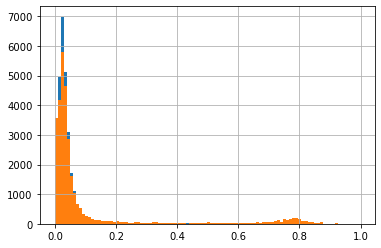

In [19]:

df_val['upper_1'] = np.array(LengthUpperTransformer().transform(df_val['less_toxic']).todense()).reshape(-1,1)
df_val['upper_2'] = np.array(LengthUpperTransformer().transform(df_val['more_toxic']).todense()).reshape(-1,1)

print(df_val['upper_1'].mean(), df_val['upper_1'].std())
print(df_val['upper_2'].mean(), df_val['upper_2'].std())

df_val['upper_1'].hist(bins=100)
df_val['upper_2'].hist(bins=100)

In [20]:
df_val['upper_1'].head(3)

0    0.026316
1    0.017167
2    0.041237
Name: upper_1, dtype: float64

## Train pipeline

- Load folds data
- train pipeline
- Predict on validation data
- Predict on test data

### Toxic data

In [21]:
val_preds_arr1 = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2 = np.zeros((df_val.shape[0], n_folds))
test_preds_arr = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv('tmp.csv')
    print(df.shape)

    features = FeatureUnion([
        #('vect1', LengthTransformer()),
        #('vect2', LengthUpperTransformer()),
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
        #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
            ("clf", Ridge()),
            #("clf",LinearRegression())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(4087, 2)

Train:

Total number of features: 32191
[('vect3__fuc', 0.57),
 ('vect3__fuck', 0.57),
 ('vect3__uck', 0.56),
 ('vect3__ fuc', 0.52),
 ('vect3__ fuck', 0.51),
 ('vect3__ fu', 0.4),
 ('vect3__shit', 0.39),
 ('vect3__ck ', 0.38),
 ('vect3__hit', 0.36),
 ('vect3__fuck ', 0.35),
 ('vect3__uck ', 0.35),
 ('vect3__ shit', 0.33),
 ('vect3__ ass', 0.28),
 ('vect3__ ass ', 0.28),
 ('vect3__ dic', 0.28),
 ('vect3__ dick', 0.28),
 ('vect3__shi', 0.28),
 ('vect3__dick', 0.27),
 ('vect3__sex', 0.27),
 ('vect3__ sex', 0.26),
 ('vect3__ shi', 0.25),
 ('vect3__ sh', 0.22),
 ('vect3__ass', 0.22),
 ('vect3__shit ', 0.22),
 ('vect3__dic', 0.21),
 ('vect3__ick', 0.21),
 ('vect3__ di', 0.2),
 ('vect3__ kil', 0.19),
 ('vect3__ kill', 0.19),
 ('vect3__ sex ', 0.19)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4087, 2)

Train:

Total number of featur

# Toxic __clean__ data

In [22]:
val_preds_arr1c = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2c = np.zeros((df_val.shape[0], n_folds))
test_preds_arrc = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv('tmp.csv')
    print(df.shape)

    features = FeatureUnion([
        #('vect1', LengthTransformer()),
        #('vect2', LengthUpperTransformer()),
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
        #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
            ("clf", Ridge()),
            #("clf",LinearRegression())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1c[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2c[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arrc[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(4087, 2)

Train:

Total number of features: 32191
[('vect3__fuc', 0.57),
 ('vect3__fuck', 0.57),
 ('vect3__uck', 0.56),
 ('vect3__ fuc', 0.52),
 ('vect3__ fuck', 0.51),
 ('vect3__ fu', 0.4),
 ('vect3__shit', 0.39),
 ('vect3__ck ', 0.38),
 ('vect3__hit', 0.36),
 ('vect3__fuck ', 0.35),
 ('vect3__uck ', 0.35),
 ('vect3__ shit', 0.33),
 ('vect3__ ass', 0.28),
 ('vect3__ ass ', 0.28),
 ('vect3__ dic', 0.28),
 ('vect3__ dick', 0.28),
 ('vect3__shi', 0.28),
 ('vect3__dick', 0.27),
 ('vect3__sex', 0.27),
 ('vect3__ sex', 0.26),
 ('vect3__ shi', 0.25),
 ('vect3__ sh', 0.22),
 ('vect3__ass', 0.22),
 ('vect3__shit ', 0.22),
 ('vect3__dic', 0.21),
 ('vect3__ick', 0.21),
 ('vect3__ di', 0.2),
 ('vect3__ kil', 0.19),
 ('vect3__ kill', 0.19),
 ('vect3__ sex ', 0.19)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4087, 2)

Train:

Total number of featur

## Ruddit data pipeline

In [23]:
val_preds_arr1_ = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2_ = np.zeros((df_val.shape[0], n_folds))
test_preds_arr_ = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv('tmp.csv')
    print(df.shape)

    features = FeatureUnion([
        #('vect1', LengthTransformer()),
        #('vect2', LengthUpperTransformer()),
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
        #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
            ("clf", Ridge()),
            #("clf",LinearRegression())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1_[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2_[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr_[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(4087, 2)

Train:

Total number of features: 32191
[('vect3__fuc', 0.57),
 ('vect3__fuck', 0.57),
 ('vect3__uck', 0.56),
 ('vect3__ fuc', 0.52),
 ('vect3__ fuck', 0.51),
 ('vect3__ fu', 0.4),
 ('vect3__shit', 0.39),
 ('vect3__ck ', 0.38),
 ('vect3__hit', 0.36),
 ('vect3__fuck ', 0.35),
 ('vect3__uck ', 0.35),
 ('vect3__ shit', 0.33),
 ('vect3__ ass', 0.28),
 ('vect3__ ass ', 0.28),
 ('vect3__ dic', 0.28),
 ('vect3__ dick', 0.28),
 ('vect3__shi', 0.28),
 ('vect3__dick', 0.27),
 ('vect3__sex', 0.27),
 ('vect3__ sex', 0.26),
 ('vect3__ shi', 0.25),
 ('vect3__ sh', 0.22),
 ('vect3__ass', 0.22),
 ('vect3__shit ', 0.22),
 ('vect3__dic', 0.21),
 ('vect3__ick', 0.21),
 ('vect3__ di', 0.2),
 ('vect3__ kil', 0.19),
 ('vect3__ kill', 0.19),
 ('vect3__ sex ', 0.19)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4087, 2)

Train:

Total number of featur

In [24]:
del df, pipeline, feature_wts
gc.collect()

591

In [25]:

print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')

 Toxic CLEAN data 
Validation Accuracy is 62.64


In [26]:

print(" Toxic CLEAN data new ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')

 Toxic CLEAN data new 
Validation Accuracy is 62.64


# Validate the pipeline 

In [27]:
print(" Toxic data ")
p1 = val_preds_arr1.mean(axis=1)
p2 = val_preds_arr2.mean(axis=1)

print(f'Validation Accuracy is { np.round((p1 < p2).mean() * 100,2)}')

print(" Ruddit data ")
p3 = val_preds_arr1_.mean(axis=1)
p4 = val_preds_arr2_.mean(axis=1)

print(f'Validation Accuracy is { np.round((p3 < p4).mean() * 100,2)}')

print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')


 Toxic data 
Validation Accuracy is 62.64
 Ruddit data 
Validation Accuracy is 62.64
 Toxic CLEAN data 
Validation Accuracy is 62.64


In [28]:
print("Find right weight")

wts_acc = []
for i in range(30,70,1):
    for j in range(0,20,1):
        w1 = i/100
        w2 = (100 - i - j)/100
        w3 = (1 - w1 - w2 )
        p1_wt = w1*p1 + w2*p3 + w3*p5
        p2_wt = w1*p2 + w2*p4 + w3*p6
        wts_acc.append( (w1,w2,w3, 
                         np.round((p1_wt < p2_wt).mean() * 100,2))
                      )
sorted(wts_acc, key=lambda x:x[3], reverse=True)[:5]

Find right weight


[(0.3, 0.7, 0.0, 62.64),
 (0.3, 0.69, 0.010000000000000009, 62.64),
 (0.3, 0.68, 0.019999999999999907, 62.64),
 (0.3, 0.67, 0.029999999999999916, 62.64),
 (0.3, 0.66, 0.039999999999999925, 62.64)]

In [29]:
w1,w2,w3,_ = sorted(wts_acc, key=lambda x:x[2], reverse=True)[0]
#print(best_wts)

p1_wt = w1*p1 + w2*p3 + w3*p5
p2_wt = w1*p2 + w2*p4 + w3*p6


## Analyze bad predictions 
### Incorrect predictions with similar scores
### Incorrect predictions with different scores

In [30]:
df_val['p1'] = p1_wt
df_val['p2'] = p2_wt
df_val['diff'] = np.abs(p2_wt - p1_wt)

df_val['correct'] = (p1_wt < p2_wt).astype('int')


In [31]:

### Incorrect predictions with similar scores

df_val[df_val.correct == 0].sort_values('diff', ascending=True).head(20)

,worker,less_toxic,more_toxic,upper_1,upper_2,p1,p2,diff,correct
111,204,"Cumulus Cloud: get a life, you loser \n\nCumulus Clouds, you have made Wikipedia a blog, not a fact based website. While you may think I am not a notable actor, the film and television industry, and my bank account disagrees with you. You need to get a life.",My promise to you all is that I'll destroy both Google and Wikipedia in less than 5 years.,0.031008,0.043478,0.433274,0.433264,0.000009,0
112,180,"Cumulus Cloud: get a life, you loser \n\nCumulus Clouds, you have made Wikipedia a blog, not a fact based website. While you may think I am not a notable actor, the film and television industry, and my bank account disagrees with you. You need to get a life.",My promise to you all is that I'll destroy both Google and Wikipedia in less than 5 years.,0.031008,0.043478,0.433274,0.433264,0.000009,0
18030,702,"""\n\nLatest EDIT\nI have amended a lot of the tabloid type rubbish information to reflect the true narrative of events, not just as seen through the emotive, myopic perspective of the hostile alien in question. My edits paint the Chinese as they truly are perceived (and even quotes from Chinese ...","How can you keep out the opinions of the SUBJECTS of this article on the basis that they are fringe? I can understand limiting or deleting entirely this group's opinions on any other page...but on the page that is FOR discussing their point of view? Please! Oh yes, and Keepcalmandcarryon is so ...",0.030837,0.038000,0.493497,0.493457,0.000040,0
18029,316,"""\n\nLatest EDIT\nI have amended a lot of the tabloid type rubbish information to reflect the true narrative of events, not just as seen through the emotive, myopic perspective of the hostile alien in question. My edits paint the Chinese as they truly are perceived (and even quotes from Chinese ...","How can you keep out the opinions of the SUBJECTS of this article on the basis that they are fringe? I can understand limiting or deleting entirely this group's opinions on any other page...but on the page that is FOR discussing their point of view? Please! Oh yes, and Keepcalmandcarryon is so ...",0.030837,0.038000,0.493497,0.493457,0.000040,0
26108,461,"""\n\nWell, it appears that that vandal has resurfaced. He's been over on the Dick Cheney page posting the same pictures. Huh. Well, guys, it looks like my little plan has caused you to think twice about who can edit the Bush page. By doing my vandal streak this morning, I have succeeded in causi...","We were winning. If stupid Doug Weller hadn't called for an RfC, the infobox would've been restored. And you've gotten learn not to give up, not till the very end. We can still win. All I'm asking is for both the warbox and the template to be in the article. Come on, don't throw in the towel yet.",0.027194,0.036789,0.548182,0.548117,0.000065,0
26110,400,"""\n\nWell, it appears that that vandal has resurfaced. He's been over on the Dick Cheney page posting the same pictures. Huh. Well, guys, it looks like my little plan has caused you to think twice about who can edit the Bush page. By doing my vandal streak this morning, I have succeeded in causi...","We were winning. If stupid Doug Weller hadn't called for an RfC, the infobox would've been restored. And you've gotten learn not to give up, not till the very end. We can still win. All I'm asking is for both the warbox and the template to be in the article. Come on, don't throw in the towel yet.",0.027194,0.036789,0.548182,0.548117,0.000065,0
26109,519,"""\n\nWell, it appears that that vandal has resurfaced. He's been over on the Dick Cheney page posting the same pictures. Huh. Well, guys, it looks like my little plan has caused you to think twice about who can edit the Bush page. By doing my vandal streak this morning, I have succeeded in causi...","We were winning. If stupid Doug Weller hadn't called for an RfC, the infobox would've been restored. And you've gotten learn not to give up, not till the very end. W

#### Some of these just look incorrectly tagged 


In [32]:
### Incorrect predictions with dis-similar scores


df_val[df_val.correct == 0].sort_values('diff', ascending=False).head(20)

,worker,less_toxic,more_toxic,upper_1,upper_2,p1,p2,diff,correct
9470,422,hey dickhole i'm gonna fuck you up assface so fuck off shitfucker\n-me,Idiot is what idiot does\n202.92.40.8,0.000000,0.025641,1.578226,0.535640,1.042586,0
25062,246,CaliforniaAliBaba is a Bitch\nGo fuck yourself you bitch ass motherfucker. Don't you ever in your fucking life threatening me you fucking piece of shit you. You don't know me I will fucking kill your ass you punk pussy bitch. tell your mama to my black dick.,I've heard a snippet on their myspace page but I'm afraid I haven't given them much though musically as of yet. Perhaps I will be purchasing one of their albums since I seem to spend about a third of my time on wiki reverting their vandalism.,0.031128,0.024390,1.414648,0.386345,1.028303,0
17192,347,fuck this this is bull shit and it does not even say where shit comes from your fucking ass,Just To Let You Know. You have no life.\nI hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I ...,0.000000,0.091365,1.470124,0.447914,1.022210,0
17193,238,fuck this this is bull shit and it does not even say where shit comes from your fucking ass,Just To Let You Know. You have no life.\nI hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I ...,0.000000,0.091365,1.470124,0.447914,1.022210,0
9520,102,by the way I AM A FUCKIN FAG FUCK U,"You are a troublemaker, a liar, and a malicious scumbag. If you are looking for trouble, then keep removing links from the article.",0.500000,0.015038,1.344696,0.385141,0.959555,0
7932,205,"|Jesus cant you guys take a few fucking jokes for fucks sake? Fucking eh you guys take this fucking shit too fucking serious, i mean what the fuck is this? Fucking Prison fucking camp? Please fucking unblock me","So because the site is owned by the company, it's ok if it's biased??? Two words - BULLSH**! You're about 30 seconds away from being labeled a walmart flunkie. And I'll be civil when you quit trying to blow smoke up my ass. If I go back and see you've re-added walmart facts, You'll wind up comi...",0.023810,0.058659,1.448337,0.530256,0.918081,0
14595,415,"Hello fuckhead,\nContributions my faggot asshole. You think that because im gay that i dont know shit. you are wrong. you just sit there with nothing to do with your pathetic fucking life that you decide to go and be a complete prick on wikipedia and just delete whatever the fuck u want. Thanks ...",User Syrthiss is a mot*herfuc*ker assh*ole ha ha ha,0.013115,0.039216,1.323518,0.456745,0.866773,0
3969,436,by the way I AM A FUCKIN FAG FUCK U,I reckon you should die,0.500000,0.041667,1.344696,0.478249,0.866448,0
17175,179,"Gon Be A Snitch \n\nYou are a little bitch. I fuckin spent 6 hours on big sam (rapper) an you call it fuckin vandolism, hard ass aint you, fuck you i'm makin a true ass page an you wack off an delete my page. What the fuck is up, your like a snitch but to yourself. I'll fuckin edit your bitch a...",INDIAN ANUS IS STRETCHED AND WIDENED BY GRAWP’S MASSIVE COCK.,0.037657,0.819672,1.324519,0.460811,0.863708,0
7788,580,suck my dick \n\nfuck you dirty whore bitch,Stop being such a sissy.,0.000000,0.040000,1.231269,0.387851,0.843418,0


# Predict on test data 

In [33]:
# Predict using pipeline

df_sub['score'] = w1*test_preds_arr.mean(axis=1) + w2*test_preds_arr_.mean(axis=1) + w3*test_preds_arrc.mean(axis=1)

In [34]:
#test_preds_arr

## Correct the rank ordering

In [35]:
# Cases with duplicates scores

df_sub['score'].count() - df_sub['score'].nunique()

15

In [36]:
same_score = df_sub['score'].value_counts().reset_index()[:10]
same_score

,index,score
0,0.419823,2
1,0.439579,2
2,0.413696,2
3,0.482831,2
4,0.479246,2
5,0.528389,2
6,0.415374,2
7,0.425713,2
8,0.471735,2
9,0.583635,2


In [37]:
df_sub[df_sub['score'].isin(same_score['index'].tolist())]

,comment_id,text,score
116,17537912,"Please stop adding nonsense to Wikipedia. It is considered vandalism. If you want to experiment, please use the sandbox. Thank you. — (Talk)",0.439579
164,19421947,"Please stop adding nonsense to Wikipedia. It is considered vandalism. If you want to experiment, please use the sandbox. Thank you. (Talk)",0.439579
1832,95080362,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.419823
2842,160935265,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.419823
4832,275797183,"Hi\n\nCould you please learn to interact like a sentient human being? Honestly, it is infuriating to read your posts which seem to be generated from a machine (Albeit, an obese one) rather than a proper, thinking, caring, functioning human being.",0.528389
4833,275812977,"Could you please learn to interact like a sentient human being? Honestly, it is infuriating to read your posts which seem to be generated from a machine (Albeit, an obese one) rather than a proper, thinking, caring, functioning human being.\n\nHi",0.528389
5140,298854514,"her!\n\nPoop, pee, toot, fart, gas, diareah!\n\nZoey is poop. She stinks.\n\nI want to marry you baby! Call me!",0.425713
5190,301925517,"her!\n\nPoop, pee, toot, fart, gas, diareah!\n\nZoey is poop. She stinks.\n\nI want to marry you baby! Call me!",0.425713
5832,345043812,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.482831
5833,345043888,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.482831


# Bert Ensemble

# Training model skip this parts

In [ ]:
import os
import gc 
import copy 
import time
import random 
import string
import pandas as pd
import numpy as np  
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import defaultdict  
from sklearn.metrics import mean_squared_error  
from sklearn.model_selection import StratifiedKFold, KFold  
from transformers import AutoTokenizer, AutoModel, AdamW  
from colorama import Fore, Back, Style

b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from transformers import logging  # lib for logging
logging.set_verbosity_warning()
logging.set_verbosity_error()

In [ ]:
import wandb
wandb.init(project="514_project", entity="dheerajp")
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"

In [ ]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits): 
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))
 
HASH_NAME = id_generator(size=12)
print(HASH_NAME)

In [ ]:
# define the configuration of our model
CONFIG = {"seed": 42, # 2021->42
          "epochs": 3, # 3->5->10->7->3
          "model_name": "roberta-base",
          "train_batch_size": 32,
          "valid_batch_size": 64,
          "max_length": 128,
          "learning_rate": 1e-4,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 25, #5->10->5->10
          "n_accumulate": 1,
          "num_classes": 1,
          "margin": 0.5,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME
          }

# 10folds * 3epochs * 13 minuts = 390 minuts = 6,5 hours  on GPU kaggle
# if Using GPU: Tesla K80 google colab it will turn out many times faster = 1,5 часа

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'

In [ ]:
# Sets the seed of the entire notebook so results are the same every time we run.
# This is for REPRODUCIBILITY
def set_seed(seed=42): 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [ ]:
df = pd.read_csv("validation_data.csv")  # create a variable dataframe containing data from the original competition data file  
print(df.shape)  # display statistics for in this file
df.head()  # display the first 5 rows of the dataframe table

In [ ]:
skf = StratifiedKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG['seed'])  # set the parameters for splitting our dataframe into data for training and testing

for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.worker)):  # dataframe splitting
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)  # add one more column of folder number to the original dataframe
df.head()  # display the first 5 rows of the dataframe table

In [ ]:
class JigsawDataset(Dataset):  # create a JigsawDataset class
    def __init__(self, df, tokenizer, max_length):  # initialization of the class at the input of the dataframe, tokenizer, max_length
        # set the class attributes
        # the __init__ function is run once when instantiating the Dataset object.
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.more_toxic = df['more_toxic'].values
        self.less_toxic = df['less_toxic'].values
        
    def __len__(self):  # the __len__ function returns the number of samples in our dataset.
        return len(self.df)
    
    def __getitem__(self, index):  # __getitem__ function loads and returns a sample from the dataset at the given index index. Based on the index, 
        # it identifies the data location on disk, encodes the data, and sets the target = 1. Finally it returns tensors of the ids, mask, target. 
        # Remember that we are using the roberta model here which does not have token_type_ids. 
        
        more_toxic = self.more_toxic[index]
        less_toxic = self.less_toxic[index]
        inputs_more_toxic = self.tokenizer.encode_plus(
                                more_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        inputs_less_toxic = self.tokenizer.encode_plus(
                                less_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        target = 1
        # Since no Target variable is present in the dataset (remember we explicitly specified Target = 1 in the dataset class), we use the Margin Ranking Loss
        # It creates a criterion that measures the loss given inputs x1, x2, two 1D mini-batch Tensors, and a label 1D mini-batch tensor y (containing 1 or -1).
        # If y = 1, then it assumed the first input should be ranked higher (should have a larger value) than the second input, and vice-versa for y = -1.
        # For the same reason, we set Target = 1 earlier.
        
        more_toxic_ids = inputs_more_toxic['input_ids']
        more_toxic_mask = inputs_more_toxic['attention_mask']
        
        less_toxic_ids = inputs_less_toxic['input_ids']
        less_toxic_mask = inputs_less_toxic['attention_mask']
        
        
        return {  # returns the obtained values
            'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
            'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
            'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
            'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
class JigsawModel(nn.Module):  # create a JigsawModel class
    def __init__(self, model_name):  # initialization of the class at the input of the dataframe, tokenizer, max_length
        # set the class attributes
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        
        return outputs  # returns the obtained values

In [ ]:
def criterion(outputs1, outputs2, targets):  # Creates a criterion that measures the loss
    return nn.MarginRankingLoss(margin=CONFIG['margin'])(outputs1, outputs2, targets)

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):  # one epoch training function
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    
    for step, data in bar:
        more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
        more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
        less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
        less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = more_toxic_ids.size(0)

        more_toxic_outputs = model(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = model(less_toxic_ids, less_toxic_mask)
        
        loss = criterion(more_toxic_outputs, less_toxic_outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss  # returns the result of the training function for one epoch

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):  # one epoch check function
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
        more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
        less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
        less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = more_toxic_ids.size(0)

        more_toxic_outputs = model(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = model(less_toxic_ids, less_toxic_mask)
        
        loss = criterion(more_toxic_outputs, less_toxic_outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss  # returns the result of the check function for one epoch

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):  # general training function
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [ ]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = JigsawDataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = JigsawDataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [ ]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [ ]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='Jigsaw', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=['roberta-base', f'{HASH_NAME}', 'margin-loss'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = JigsawModel(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()
print('Сompleted training and saving models!')

# Start from here

In [ ]:
%%time
# connect libraries only for this task
import os  # operating system library
import gc  # Garbage Collector - module provides the ability to disable the collector, tune the collection frequency, and set debugging options
import cv2  # open source computer vision and machine learning library
import copy  # The assignment operation does not copy the object, it only creates a reference to the object. 
# For mutable collections, or for collections containing mutable items, a copy is often needed so that it can be modified without changing the original. 
# This module provides general (shallow and deep) copy operations. 

import time  # time library
import random  # library for working with random values

# For data manipulation
import pandas as pd  # data analysis library
import numpy as np  # library linear algebra, Fourier transform and random numbers

# Pytorch Imports
import torch  #  a Tensor library like NumPy, with strong GPU support
import torch.nn as nn  # a neural networks library deeply integrated with autograd designed for maximum flexibility
from torch.utils.data import Dataset, DataLoader  # DataLoader and other utility functions for convenience


# For Transformer Models
from transformers import AutoTokenizer, AutoModel  # In many cases, the architecture you want to use can be guessed from the name or the path of the 
# pretrained model you are supplying to the from_pretrained() method. AutoClasses are here to do this job for you so that you automatically retrieve the 
# relevant model given the name/path to the pretrained weights/config/vocabulary.
#Instantiating one of AutoConfig, AutoModel, and AutoTokenizer will directly create a class of the relevant architecture.

# Utils
from tqdm import tqdm  # tqdm derives from the Arabic word taqaddum  which can mean "progress," and is an abbreviation for "I love you so much" in Spanish 
# (te quiero demasiado).  this library show a smart progress meter - just wrap any iterable with tqdm(iterable)

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = dict(
    seed = 42,
    model_name = 'roberta-base',
    test_batch_size = 64,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

MODEL_PATHS = [
    'models/Loss-Fold-0.bin',
    'models/Loss-Fold-1.bin',
    'models/Loss-Fold-2.bin',
    'models/Loss-Fold-3.bin',
    'models/Loss-Fold-4.bin'
]

def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS


def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    return final_preds


set_seed(CONFIG['seed'])
df = pd.read_csv("comments_to_score.csv")
df.head()

test_dataset = JigsawDataset(df, CONFIG['tokenizer'], max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['test_batch_size'],
                         num_workers=2, shuffle=False, pin_memory=True)

preds1 = inference(MODEL_PATHS, test_loader, CONFIG['device'])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 1


In [ ]:
preds = (preds1-preds1.min())/(preds1.max()-preds1.min())

In [ ]:
df_sub['score'] = df_sub['score']*0.85+preds*0.15 #0.82->0.85->0.90, 0.17->0.15->0.10

In [ ]:
df_sub[['comment_id', 'score']].to_csv("submission.csv", index=False)